In [1]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
from matplotlib import colors
import random
import time

# Integer Program Formulation
This notebook outlines an integer programming perspective on the Covid-19 scheduling problem. In its current iteration, this model schedules people on a week-by-week basis, ensuring that people take $F_i = 2$ tests per week (if feasible, i.e. available at least 2 days) and attempting to keep the number of tests on any given day below a reasonable bound.

Our latest iteration involves splitting up a day into $n\_blocks = 3$ blocks and scheduling people to test at some point during one of the blocks. Therefore the optimized variable is $assignment$, a $(n\_people, n\_blocks \times n\_days)$ binary matrix where each row is the schedule for one person. Every $n\_blocks$ entries represents one day, and a 0 in one entry means no test on that block, 1 means test. We can incorporate $avail$, which is a $(n\_people, n\_blocks \times n\_days)$ binary matrix that marks when people are on campus (0 is not on campus, 1 is on campus and available to test). This way, multiplying $avail$ by $assignment$ elementwise and computing the row-sums gives a $ n\_people $ vector with the counts of well-scheduled tests that $n\_days$ (usually week) for each person. Moreover, computing the column-sums $ assignment$ gives the total number of tests per block, which we want to keep fairly even.

<!-- The optimized variable is $assignment$, a $(n\_people, n\_days)$ binary matrix where each row is the weekly schedule for one person, where 0 means 'no test' and 1 means 'test'. We can incorporate $avail$, which is a $(n\_people, n\_days)$ binary matrix that marks on which days people are on campus (0 is not on campus, 1 is on campus and available to test). This way, multiplying $avail$ by $assignment$ elementwise and summing across rows gives a $ n\_people $ vector with the counts of well-scheduled tests that week for each person. Moreover, summing $ assignment$ across columns gives the total number of tests per day, which we want to keep fairly even. -->

# setup

One important aspect is creating a realistic schedule on which to test our model. It's not as simple as just letting everyone have random availability. It would be nice to have a tool that allows you to tweak the specific scheduling parameters for different campuses. Here are things we should consider:
* Split campus community members into three groups — students, faculty, staff
* A large proportion of students should be available 7 days a week, since they live on campus
* The rest of the students should be available on the weekends and either on MWF or TTh (this is at least the case at UChicago — should investigate more)
* Professors should be available 1-2 days a week, never on weekends
  * If 2 days a week, not consecutive days?
* Staff ??? depends on the staff, need to think more about this.

In [11]:
def runIP(n_people, n_blocks, buffer=0.2, n_days=7, test_interval=3.5, pcts=[.7,.2,1]):
    
    # Create matrices to identify tests on consecutive or same days
    def make_constraints(n_days, n_blocks):
        consecs = np.zeros((n_blocks**2, 2*n_blocks))
        for i in range(n_blocks**2):
            for j in range(2*n_blocks):
                consecs[i][int(np.floor(i/n_blocks))] = 1
                consecs[i][int(n_blocks + np.floor(i%n_blocks))] = 1
        possible_adjs = (n_blocks**2) * (n_days-1)
        adjacencies = np.zeros((possible_adjs, 1*n_blocks * n_days)) # quadratic w. number of blocks
        for i in range(n_days - 1):
            adjacencies[(n_blocks**2) *i:(n_blocks**2) * (i+1), n_blocks*i:n_blocks*i + 2*n_blocks] = consecs
        sameDays = np.zeros((n_days, n_blocks*n_days))
        for i in range(len(sameDays)):
            idx = n_blocks*i
            for j in range(n_blocks):
                sameDays[i][idx + j] = 1
        # To highlight only evenings
        evenings = np.zeros((n_people, n_blocks*n_days))
        for i in range(n_people):
            for j in range(n_blocks*n_days):
                if j % n_blocks == n_blocks - 1:
                    evenings[i][j] = 1
        bridge = np.zeros((n_people, 2*n_blocks*n_days))
        for i in range(n_people):
            for j in range(2*n_blocks*n_days):
                if j < (n_blocks*(n_days+1)) and j >= (n_blocks*(n_days-1)):
                    bridge[i][j] = 1
        return adjacencies, sameDays, evenings, bridge
    
    # Set-up non-deterministic schedules for each IP run
    def runSetup(pcts, n_people, n_days, n_blocks, n_tests):
        def make_avails_random(n_people, n_days, n_blocks):
            avail = np.random.randint(0,2, size=(n_people, n_blocks*n_days))
            avail_days = np.zeros((n_people, n_days))
            for i in range(n_people):
                for j in range(n_days):
                    isAvail = False
                    for k in range(n_blocks):
                        if avail[i][j*n_blocks + k] == 1:
                            isAvail = True
                    if isAvail:
                        avail_days[i][j] = 1
            return avail, avail_days

        def make_avails(student_pct, prof_pct, staff_pct):
            weeks = {'fully_avail':[1,1,1,1,1,1,1], 'mwf':[1,0,1,0,1,1,1], 'tth':[0,1,0,1,0,1,1],
                     '1prof1':[1,0,0,0,0,0,0], '1prof2':[0,1,0,0,0,0,0], '1prof3':[0,0,1,0,0,0,0],
                     '1prof4':[0,0,0,1,0,0,0], '1prof5':[0,0,0,0,1,0,0], '1prof1':[1,0,0,0,0,0,0],
                     '2prof1':[1,0,1,0,0,0,0], '2prof2':[0,1,0,1,0,0,0], '2prof3':[0,0,1,0,1,0,0]}
            avail = np.zeros((n_people, n_days))
            for row in range(len(avail)):
                member = random.uniform(0,1)
                if member < student_pct: 
                    studentAvail = random.uniform(0,1)
                    if studentAvail < 0.7:
                        avail[row] = weeks['fully_avail']
                        continue
                    else:
                        flipCoin = random.uniform(0,1)
                        if flipCoin < 0.5:
                            avail[row] = weeks['mwf']
                            continue
                        else:
                            avail[row] = weeks['tth']
                            continue
                elif member < student_pct + prof_pct + staff_pct: # treat staff same as profs (for now)
                    oneOrTwo = random.uniform(0,1)
                    if oneOrTwo < 0.7: # 70% chance profs/staff are one campus 1x a week
                        i = '1'
                        day = str(random.randint(1,5))
                        avail[row] = weeks[i + 'prof' + day]
                        continue
                    else:
                        i = '2'
                        day = str(random.randint(1,3))
                        avail[row] = weeks[i + 'prof' + day]
                        continue
            return avail

        avail, avail_days = make_avails_random(n_people, n_days, n_blocks) # truly random availability
    #     avail = make_avails(pcts[0], pcts[1], pcts[2]) # more realistic -- not in parallel to random one!
        people_total_availability = np.sum(avail_days, 1)
        infeasible_people = np.where(people_total_availability < n_tests)
        unshiftable_people = np.where(people_total_availability <= n_tests)
        necessary_tests = np.multiply(n_tests, np.ones((n_people,)))
        for i in range(len(infeasible_people[0])):
            necessary_tests[infeasible_people[0][i]] = people_total_availability[infeasible_people[0][i]]
        spaces = np.ones((n_people,))
        for i in range(len(unshiftable_people[0])):
            spaces[unshiftable_people[0][i]] += 1 
        avg_daily_tests_value = (n_people*n_tests/n_days)
        avg_daily_tests = np.multiply(avg_daily_tests_value, np.ones((n_days,)))

        # Calculate the average number of tests per block
        avg_block_tests_value = avg_daily_tests_value / n_blocks
        avg_block_tests = np.multiply(avg_block_tests_value, np.ones((n_blocks * n_days,)))

        return avail, avg_daily_tests, avg_block_tests, necessary_tests, spaces
    
    assignment = cp.Variable((n_people, n_blocks * n_days), boolean=True)
    adjacencies, sameDays, evenings, bridge = make_constraints(n_days, n_blocks)
    avail, avg_daily_tests, avg_block_tests, necessary_tests, spaces = runSetup(pcts, n_people, n_days, n_blocks, n_days/test_interval)
    
    constraints = [
        cp.sum(assignment, axis=0) <= np.ceil(avg_block_tests * (1 + buffer)), # set load ub
        cp.sum(assignment, axis=0) >= np.floor(avg_block_tests * (1 - buffer)), # set load lb
        cp.sum(assignment, axis=1) == necessary_tests, # enforce taking F_i tests
        cp.sum(cp.multiply(assignment, avail), axis=1) == necessary_tests # align with availability
    ]
    # If day is subdivided, underschedule the last block
    if n_blocks > 1:
        constraints.append(cp.sum(cp.multiply(assignment, evenings), axis=0) <= np.ceil(avg_block_tests * (1 + buffer/2)))
    # Ensure that nobody is scheduled more than once each day
    for i in range(n_days):
        same = sameDays[i]*np.ones((n_people,1))
        constraints.append(cp.sum(cp.multiply(assignment, same), axis=1) <= np.ones((n_people,)))
    # Ensure each person has no consecutive days scheduled, unless that's all they can do
    for i in range(len(adjacencies)):
        consec = adjacencies[i]*np.ones((n_people,1))
        constraints.append(cp.sum(cp.multiply(assignment, consec), axis=1) <= spaces)
    # Ensure nobody tests on Monday if they had tested on Sunday (unless they have to)
    twoWeeks = cp.hstack((prevAssignment, assignment))
    constraints.append(cp.sum(cp.multiply(twoWeeks, bridge), axis=1) <= spaces)
#     obj = cp.Minimize(objective()) # Spread objective function (not working)
    obj = cp.Maximize(cp.sum(assignment)) # Dummy objective function
    prob = cp.Problem(obj, constraints=constraints)
    prob.solve()
    return assignment, avail

In [12]:
def analyzeIP(assignment, n_people, n_blocks, n_days=7, test_interval=3.5):
    sched_days = np.zeros((n_people, n_days))
    sched_blocks = assignment.value
    for i in range(n_people):
        for j in range(n_days):
            isAvail = False
            for k in range(n_blocks):
                if sched_blocks[i][j*n_blocks + k] == 1:
                    isAvail = True
            if isAvail:
                sched_days[i][j] = 1
    # Compute spread score (lower is better)
    score = 0
    for week in sched_days:
        scheduled_days = []
        for i in range(n_days):
            if week[i] == 1:
                scheduled_days.append(i)
        if len(scheduled_days) == 2:
            score += ((scheduled_days[1] - scheduled_days[0]) - test_interval) ** 2
    spreadScore = score / n_people
    # Compute block demands, deviations
    block_demands = np.sum(assignment.value, axis=0)
    daily_demands = [sum(block_demands[i:i+n_blocks]) for i in range(0, n_blocks*n_days - 1, n_blocks)]
    exp_supply_per_block = n_people / (n_blocks * test_interval)
    exp_supply_per_day = n_people / test_interval
    max_deviation = max(block_demands.max() - exp_supply_per_block,
                        exp_supply_per_block - block_demands.min()) / exp_supply_per_block
    max_daily_deviation = max(max(daily_demands) - exp_supply_per_day,
                        exp_supply_per_day - min(daily_demands)) / exp_supply_per_day
    return spreadScore, block_demands, daily_demands, max_deviation, max_daily_deviation

In [13]:
def showLast(assignment, avail, n_people, n_blocks, spreadScore, block_demands, daily_demands, max_deviation, max_daily_deviation, n_days=7):
    print("Spread score is: %.02f" % spreadScore)
    print("Max block deviation %% is: %.01f" % (100 * max_deviation))
    print("Max daily deviation %% is: %.01f" % (100 * max_daily_deviation))
    print('All block demands:', block_demands)
    print('All daily demands:', daily_demands)
    if n_people < 1000:
        # Display Calendar
        scaled_assignment = np.multiply(assignment.value, 0.5)
        data = np.add(scaled_assignment, avail)
        prevData = prevAssignment
        for i in range(n_people):
            for j in range(n_blocks*n_days):
                if prevData[i][j] == 1:
                    prevData[i][j] = 1.5
        finalData = np.concatenate((prevData, data), axis=1)
        outputColors = colors.ListedColormap(['gray', 'lightgray', 'lightgreen', 'red', 'yellow', 'green'])
        plt.figure(num=1, figsize=(16,n_people/4))
        plt.title("Previous Week   | Upcoming Week", fontsize=16)
        plt.imshow(finalData, cmap=outputColors, aspect='auto', extent=[0, 2*n_days, n_people, 0])
        plt.axvspan(0, n_days, facecolor='0.8', alpha=0.5)
        plt.grid(which='major', axis='both', linestyle='-', color='k', linewidth=1.2)
        plt.xticks(np.arange(0,2*n_days, 1))
        plt.yticks(np.arange(0, n_people, 1))
        plt.xlabel("Day", fontsize=12)
        plt.ylabel("Person", fontsize=12)
        plt.savefig('output.png', dpi=300, bbox_inches='tight')
        plt.show()
    return assignment

In [14]:
def runTrials(n_trials, n_people, n_blocks):
    times = []
    spreads = []
    maxDevs = []
    maxDailyDevs = []
    infeasibles = 0
    for _ in range(n_trials):
        if (_ % 10 == 0):
            print(_)
        begin = time.perf_counter()
        assignment, avail = runIP(n_people, n_blocks)
        end = time.perf_counter()
        if assignment.value is not None:
            spreadScore, block_demands, daily_demands, max_deviation, max_daily_deviation = analyzeIP(assignment, n_people, n_blocks)
            times.append(end-begin)
            spreads.append(spreadScore)
            maxDevs.append(max_deviation)
            maxDailyDevs.append(max_daily_deviation)
#             print('Optimization done.')
        else:
            infeasibles += 1
#             print('Situation infeasible.')
    print("There were %d infeasibles" % infeasibles)
    print()
    if assignment.value is not None:
        print("Summary of last IP run...")
        assignment = showLast(assignment, avail, n_people, n_blocks, spreadScore, block_demands, daily_demands, max_deviation, max_daily_deviation)
    else:
        print("Last IP run infeasible :(")
    return times, spreads, maxDevs, maxDailyDevs, assignment.value

In [15]:
def plotTrials(times, spreads, maxDevs, n_trials, n_people, n_blocks, buffer=0.2):
    fig, ax = plt.subplots(1,3, figsize=(16,4))
    fig.suptitle("%d people, %d blocks, random availability" % (n_people, n_blocks), fontsize=16)
    
    ax[0].set_title("Runtime", fontsize=12)
    ax[0].set_xlabel("seconds", fontsize=12)
    ax[0].hist(times)
    
    
    ax[1].set_title("Spread Score", fontsize=12)
    ax[1].set_xlabel("squared distance from ideal test_interval", fontsize=12)
    ax[1].hist(spreads)
    
    ax[2].set_title("Max Deviation (capped at ~ %.02f)" % buffer, fontsize=12)
    ax[2].set_xlabel("% deviation from avg", fontsize=12)
    ax[2].hist(maxDevs)
    
#     fig.show()
    fig.savefig("p" + str(n_people) + "b" + str(n_blocks) + "_x" + str(n_trials) + ".png", dpi=300)

In [9]:
# Need this to seed a previous week (comment out last constraint in runIP)
# prevAssignment, avail = runIP(20, 3)
# prevAssignment = prevAssignment.value
# Once this is run, uncomment last constraint in runIP

0
There were 0 infeasibles

Summary of last IP run...
Spread score is: 2.05
Max block deviation % is: 57.5
Max daily deviation % is: 47.5
All block demands: [3. 2. 2. 3. 3. 1. 1. 3. 1. 1. 1. 2. 1. 1. 1. 2. 2. 2. 2. 3. 3.]
All daily demands: [7.0, 7.0, 5.0, 4.0, 3.0, 6.0, 8.0]


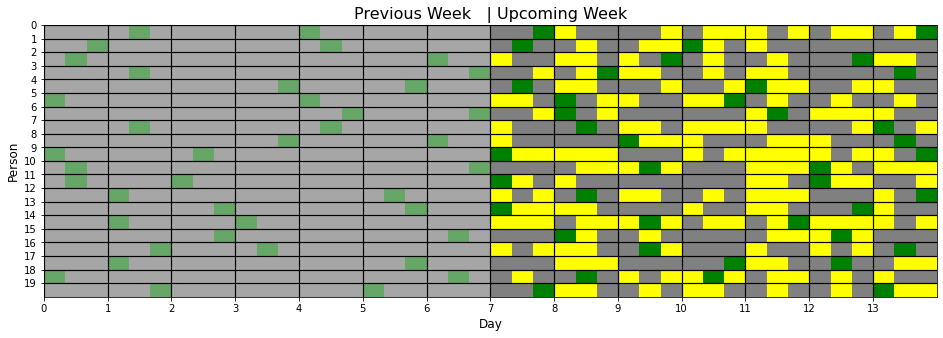

In [17]:
times, spreads, maxDevs, maxDailyDevs, prevAssignment = runTrials(1, 20, 3)

In [ ]:
plotTrials(times, spreads, maxDevs, 100, 20, 3)